## What to do
We need to:
 - Choose a transitive verb (minimum valence = 2) &rarr; **EAT**
 - Retrieve from a corpus n (> 1000) instances in which it is used &rarr; I composed a corpus merging two pre-processed corpora: [corpora_1](https://sentence.yourdictionary.com/eat) and [corpora_2](https://wortschatz.uni-leipzig.de/en/download/English)
 - Perform parsing and disambiguation
 - Use wordnet supersenses on the arguments (subj and obj in the case of 2 arguments) of the chosen verb
 - Aggregate the results, compute the frequencies, print semantic clusters obtained
    - A semantic cluster is intended as a combination of semantic types (i.e. pairs of sem_types if valence = 2)


In [1]:
import nltk
from nltk.corpus import wordnet
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader.wordnet import Synset
import re
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Set, Tuple, Union

### Data Load

In [2]:
root_dir = '..'


# Load stop words from file
def import_stop_words() -> Set[str]:
    with open(f'{root_dir}/common-data/stop_words_FULL.txt') as f:
        stop_words = {line for line in f.read().splitlines()}
    return stop_words


def import_sentences() -> List[str]:
    with open('data/eat_corpora.txt', encoding='utf-8') as f:
        sentences = f.read().splitlines()
    return sentences


stop_words = import_stop_words()
sentences = import_sentences()

### Pre-processing

In [3]:
# Pre-processing of a sentence
def bag_of_words(sentence: str) -> Set[str]:
    return set(remove_stopwords(tokenize_sentence(remove_punctuation(sentence))))


# Remove stopwords from a word list
def remove_stopwords(words: List[str]) -> List[str]:
    return [value.lower() for value in words if value.lower() not in stop_words]


# Get tokens from sentence
def tokenize_sentence(sentence) -> List[str]:
    words = []
    lmtzr = WordNetLemmatizer()
    for tag in nltk.pos_tag(word_tokenize(str(sentence))):
        if tag[1][:2] == "NN":
            words.append(lmtzr.lemmatize(tag[0], pos=wordnet.NOUN))
        elif tag[1][:2] == "VB":
            words.append(lmtzr.lemmatize(tag[0], pos=wordnet.VERB))
        elif tag[1][:2] == "RB":
            words.append(lmtzr.lemmatize(tag[0], pos=wordnet.ADV))
        elif tag[1][:2] == "JJ":
            words.append(lmtzr.lemmatize(tag[0], pos=wordnet.ADJ))
    return words


# Remove punctuation and multiple spaces
def remove_punctuation(sentence: str) -> str:
    return re.sub('\s\s+', ' ', re.sub(r'[^\w\s]', '', sentence))

### Word Sense Disambiguation

In [4]:
def disambiguate_terms(pattern: Union[Tuple[str], str]) -> Synset:
    dep1 = pattern[0]
    dep2 = pattern[1]
    sentence = pattern[2]

    w1 = dep1[0]
    w2 = dep2[0]
    
    # WSD with nltk Lesk
    return lesk(tokenize_sentence(sentence), w1, 'n'), lesk(tokenize_sentence(sentence), w2, 'n')

### Patterns Finding

In [5]:
def search_obj(sentence: str, verb: str, pattern: List[Tuple[str]]) -> Tuple[str]:
    for token in sentence:
        if token.head.text == verb and token.dep_ == 'dobj' and len(pattern) < 2 and token.text != '\n  ' and token.text != '\n':
            dep2 = token.text, token.tag_, token.head.text, token.dep_
            return dep2


def find_patterns() -> List[Union[Tuple[str], str]]:
    verb_forms = ['eat', 'eats']

    # Valence
    num_args = 2

    # Load spacy
    nlp = spacy.load('en_core_web_sm')

    patterns = []
    for sentence in sentences:
        parsed_sentence = nlp(sentence)
        pattern = []

        for token in parsed_sentence:
            # If token is a subject we can find subjects
            if token.head.text in verb_forms and token.dep_ == 'nsubj' and len(pattern) < num_args:
                dep1 = token.text, token.tag_, token.head.text, token.dep_
                pattern.append(dep1)
                dep2 = search_obj(parsed_sentence, token.head.text, pattern)
                if dep2:
                    pattern.append(dep2)

            # Append iff we have 2 arguments
            if len(pattern) == num_args:
                pattern.append(parsed_sentence)
                patterns.append(pattern)
    
    return patterns

### Semantic Clustering

In [6]:
def compute_semantic_clusters(patterns: List[Union[Tuple[str], str]]) -> List[Tuple[str]]:
    new_patterns = []
    for pattern in patterns:
        best_sense1, best_sense2 = disambiguate_terms(pattern)
        
        if best_sense1 and best_sense2:
            # get supersenses from the synsets
            new_patterns.append((best_sense1._lexname.split('.')[1], best_sense2._lexname.split('.')[1]))
        

    # Create a dict of Counter. Res like ((supersense1, supersense2), frequency)
    patterns_counter = dict(Counter(new_patterns))
    semantic_clusters = []
    
    for key, count in patterns_counter.items():
        percentage = count / len(new_patterns) * 100
        cluster = (key, f"{percentage:.2f}%")
        semantic_clusters.append(cluster)

    # sort clusters by frequency
    semantic_clusters = sorted(semantic_clusters, key=lambda x: x[1], reverse=True)
    return semantic_clusters

### Computation

In [7]:
patterns = find_patterns()
print("Patterns found: ", len(patterns))

# Obtain semantic clusters with frequency 
semantic_clusters = compute_semantic_clusters(patterns)

# Print clusters
print('\nCluster list with probability: ')
for cluster in semantic_clusters:
    print(cluster)

# Check if probabilities are consistent
print(f'\nSum of all probabilities: {round(sum(float(semantic_clusters[i][1][:-1]) for i in range(len(semantic_clusters))))}%')

Patterns found:  402

Cluster list with probability: 
(('person', 'food'), '6.01%')
(('quantity', 'food'), '6.01%')
(('group', 'food'), '5.46%')
(('quantity', 'cognition'), '4.37%')
(('substance', 'food'), '3.28%')
(('group', 'artifact'), '2.73%')
(('person', 'person'), '2.19%')
(('group', 'cognition'), '2.19%')
(('substance', 'person'), '1.64%')
(('artifact', 'cognition'), '1.64%')
(('quantity', 'person'), '1.64%')
(('substance', 'cognition'), '1.64%')
(('substance', 'artifact'), '1.64%')
(('quantity', 'substance'), '1.64%')
(('person', 'cognition'), '1.64%')
(('animal', 'food'), '1.64%')
(('person', 'Tops'), '1.64%')
(('animal', 'person'), '1.64%')
(('group', 'animal'), '1.09%')
(('group', 'act'), '1.09%')
(('quantity', 'quantity'), '1.09%')
(('quantity', 'attribute'), '1.09%')
(('artifact', 'body'), '1.09%')
(('quantity', 'animal'), '1.09%')
(('cognition', 'cognition'), '1.09%')
(('cognition', 'possession'), '1.09%')
(('person', 'quantity'), '1.09%')
(('group', 'Tops'), '1.09%')
(('

### Plotting

<BarContainer object of 94 artists>

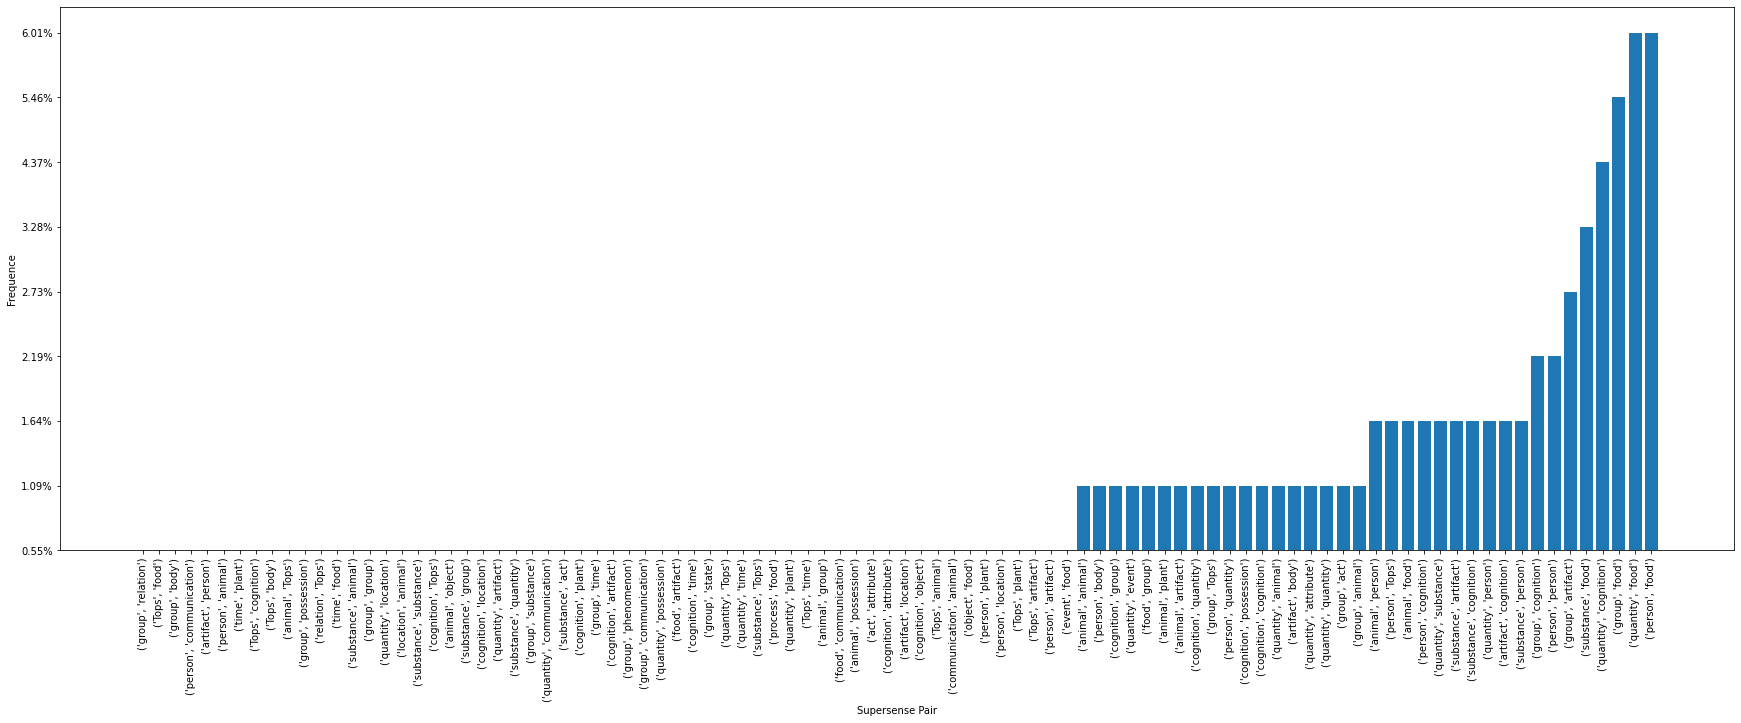

In [8]:
semantic_clusters.reverse()
supersense_pairs = [str(entry[0]) for entry in semantic_clusters]
frequences = [entry[1] for entry in semantic_clusters]

fig = plt.figure(figsize=(30, 10))

plt.xlabel("Supersense Pair")
plt.ylabel("Frequence")
plt.xticks(rotation=90)
plt.bar(supersense_pairs, frequences)